## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [4]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc').sel(time=slice('1980', '2018'))

monthly_aht_ds = xr.open_dataset('../aht_time_series/aaron_aht_data_through_2018_with_time.nc').sel(time=slice('1980', '2018'))

era5_aht_ds = xr.open_dataset('../era5_raw_data/era5_aht_data/era5_aht_ds').sel(time=slice('1980', '2018'))

In [8]:
lats_fine = era5_aht_ds.latitude
lons_fine = era5_aht_ds.longitude

### Plot it

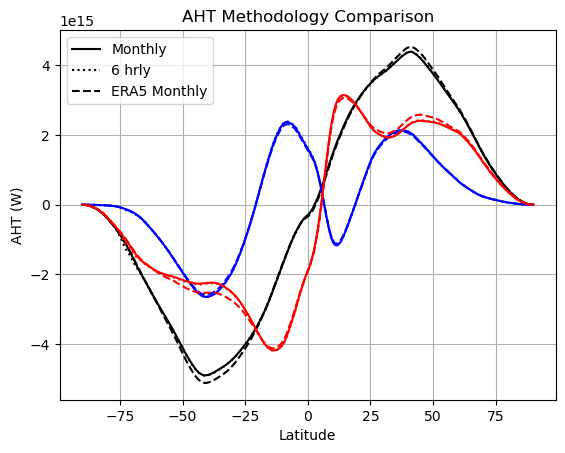

In [30]:
plt.plot(lats, monthly_aht_ds.total_aht.mean(['time']), '-', color='k', label='Monthly')

plt.plot(lats, aht_ds.total_aht.mean(['time']), ':', color='k', label='6 hrly')

plt.plot(lats_fine, era5_aht_ds.total_aht.mean(['longitude', 'time']), '--', color='k', label='ERA5 Monthly')


plt.plot(lats, monthly_aht_ds.total_aht_moist.mean(['time']), '-', color='b')

plt.plot(lats, aht_ds.total_aht_moist.mean(['time']), ':', color='b')

plt.plot(lats_fine, era5_aht_ds.latent_aht.mean(['longitude', 'time']), '--', color='b')


plt.plot(lats, monthly_aht_ds.total_aht_dry_pot.mean(['time']), '-', color='r')

plt.plot(lats, aht_ds.total_aht_dry.mean(['time']), ':', color='r')

plt.plot(lats_fine, era5_aht_ds.dry_aht.mean(['longitude', 'time']), '--', color='r')


plt.grid()

plt.legend(loc=0)

plt.xlabel('Latitude')

plt.ylabel('AHT (W)')

plt.title('AHT Methodology Comparison')

#plt.savefig('../figures/aht_changes/aht_clima_methodology_comparisons')

plt.show()

### Need to regrid Aaron's AHT data in order to look at anomalies

In [28]:
era5_aht_ds_coarse = era5_aht_ds.interp(latitude=lats)

### Now look at anomalies

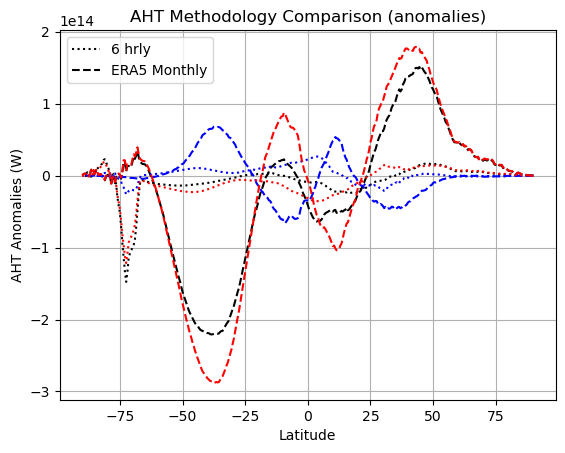

In [29]:
plt.plot(lats, aht_ds.total_aht.mean(['time']) - monthly_aht_ds.total_aht.mean(['time']),
         ':', color='k', label='6 hrly')

plt.plot(lats, era5_aht_ds_coarse.total_aht.mean(['longitude', 'time']) - monthly_aht_ds.total_aht.mean(['time']),
         '--', color='k', label='ERA5 Monthly')


plt.plot(lats, aht_ds.total_aht_moist.mean(['time']) - monthly_aht_ds.total_aht_moist.mean(['time']),
         ':', color='b')

plt.plot(lats, era5_aht_ds_coarse.latent_aht.mean(['longitude', 'time']) - monthly_aht_ds.total_aht_moist.mean(['time']),
         '--', color='b')


plt.plot(lats, aht_ds.total_aht_dry.mean(['time']) - monthly_aht_ds.total_aht_dry_pot.mean(['time']),
         ':', color='r')

plt.plot(lats, era5_aht_ds_coarse.dry_aht.mean(['longitude', 'time']) - monthly_aht_ds.total_aht_dry_pot.mean(['time']),
         '--', color='r')


plt.grid()

plt.legend(loc=0)

plt.xlabel('Latitude')

plt.ylabel('AHT Anomalies (W)')

plt.title('AHT Methodology Comparison (anomalies)')

#plt.savefig('../figures/aht_changes/aht_anomalies_methodology_comparisons')

plt.show()

### Make a map of the ERA5 data

In [12]:
clima_aht = era5_aht_ds.total_aht.mean(['time']).load()

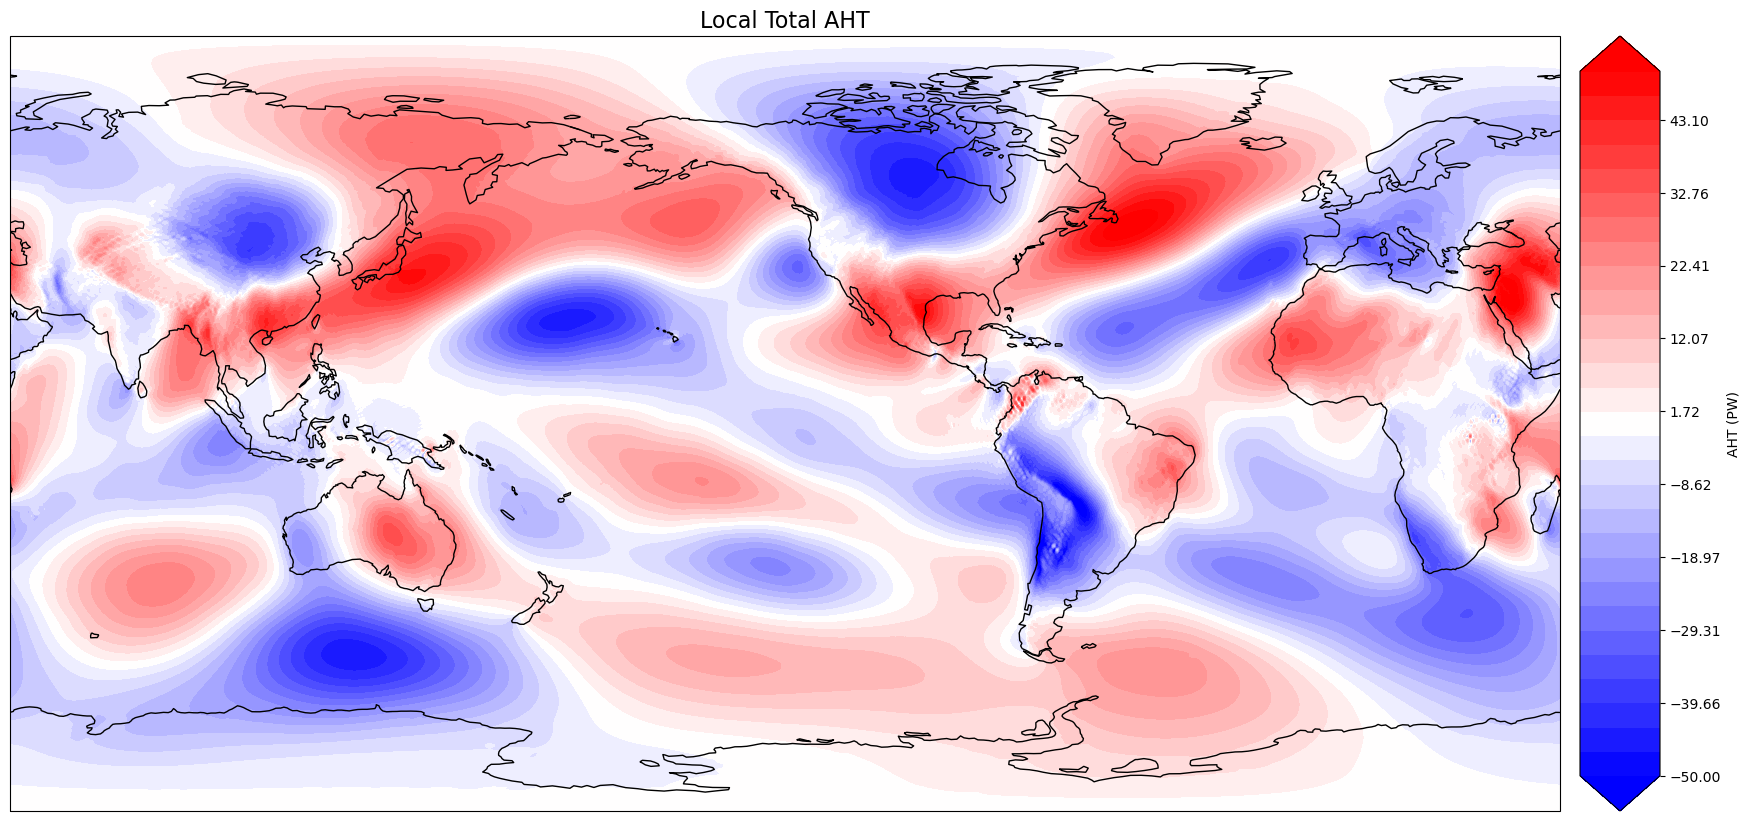

In [14]:
fig=plt.figure(figsize=(20,30))


ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-130))
ax.coastlines()

contf = ax.contourf(lons_fine, lats_fine, clima_aht/1e15, levels=np.linspace(-50, 50, 30), cmap='bwr',
                    transform=ccrs.PlateCarree(), extend='both')

#contf.cmap.set_over('grey')
#contf.cmap.set_under('grey')
#contf.changed()

#ax.contour(lons, test_lats, extreme_ratios, levels=[0.55], colors='limegreen', transform=ccrs.PlateCarree())

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])


plt.colorbar(contf, cax=pos_cax, label='AHT (PW)')

ax.set_title('Local Total AHT', fontsize=16)
#plt.savefig('../figures/aht_changes/local_aht_era5_data')
plt.show()